In [1]:
import argparse
import os.path as osp
import os

import mmcv
import torch
from mmcv import Config, DictAction
from mmcv.parallel import MMDataParallel
from mmcv.runner import init_dist, load_checkpoint

from mmdet.datasets import build_dataloader, build_dataset
from mmdet.models import build_detector
from mmdet.core import encode_mask_results, tensor2imgs
import matplotlib.pyplot as plt
import numpy as np


In [2]:
config_file = 'configs/gcnet/mask_rcnn_r50_fpn_syncbn-backbone_r16_gcb_c3-c5_1x_coco.py'
checkpoint_file = 'checkpoints/mask_rcnn_r50_fpn_syncbn-backbone_r16_gcb_c3-c5_1x_coco_20200202-587b99aa.pth'


In [3]:
hidden_outputs = {}


def context_mask_hook(name):
    def hook(module, input, output):
        x = input[0]
        batch, channel, height, width = x.size()
        # [N, 1, H, W]
        context_mask = module.conv_mask(x)
        # [N, 1, H * W]
        context_mask = context_mask.view(batch, 1, height * width)
        # [N, H, W]
        context_mask = module.softmax(context_mask)

        hidden_outputs[name] = context_mask.view(batch, height, width)

    return hook


def register_context_mask_hook(model):
    for module_name, module in model.module.named_modules():
        if 'ContextBlock' in str(module.__class__) and 'layer4.1' in module_name:
            module.register_forward_hook(context_mask_hook(module_name))
            print(f'{module_name} is registered')


def single_gpu_vis(model,
                   data_loader,
                   show=False,
                   out_dir=None):
    model.eval()
    register_context_mask_hook(model)

    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))
    for i, data in enumerate(data_loader):
        with torch.no_grad():
            model(return_loss=False, rescale=True, **data)

        if show or out_dir:
            img_tensor = data['img'][0]
            img_metas = data['img_metas'][0].data[0]
            imgs = tensor2imgs(img_tensor, **img_metas[0]['img_norm_cfg'])
            assert len(imgs) == len(img_metas)

            for img, img_meta in zip(imgs, img_metas):
                h, w, _ = img_meta['img_shape']
                img_show = img[:h, :w, :]
                img_show = mmcv.bgr2rgb(img_show)

                ori_h, ori_w = img_meta['ori_shape'][:-1]
                img_show = mmcv.imresize(img_show, (ori_w, ori_h))

                
                for hidden_name, hidden_output in hidden_outputs.items():
                    plt.imshow(img_show)

                    hidden_output_np = hidden_output.detach().cpu().numpy()[0]
                    att_map = hidden_output_np.copy()
                    att_map[hidden_output_np < (np.percentile(hidden_output_np, 80))] = hidden_output_np.min()
                    att_map[hidden_output_np > (np.percentile(hidden_output_np, 95))] = np.percentile(hidden_output_np, 95)
                    hidden_output_show = mmcv.imresize_like(hidden_output_np, img_show)
#                     plt.imshow(hidden_output_show / hidden_output_show.max(), cmap='viridis',
#                                interpolation='bilinear', vmin=0., vmax=1., alpha=0.5)
                    plt.imshow(hidden_output_show, cmap='jet', interpolation='bilinear', alpha=0.3)
                    if out_dir is not None:
                        dst_dir = osp.join(out_dir, hidden_name)
                        mmcv.mkdir_or_exist(dst_dir)
                        print(f"saving {osp.join(dst_dir, img_meta['ori_filename'])}")
                        plt.savefig(osp.join(dst_dir, img_meta['ori_filename']))
                    else:
                        plt.title(img_meta['ori_filename'] + hidden_name)
                        plt.show()
                    plt.clf()
                    import pdb
                    pdb.set_trace()

        hidden_outputs.clear()

        batch_size = len(data['img_metas'][0].data)
        for _ in range(batch_size):
            prog_bar.update()




In [4]:
cfg = Config.fromfile(config_file)
# set cudnn_benchmark
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True
cfg.model.pretrained = None
if cfg.model.get('neck'):
    if cfg.model.neck.get('rfp_backbone'):
        if cfg.model.neck.rfp_backbone.get('pretrained'):
            cfg.model.neck.rfp_backbone.pretrained = None
cfg.data.test.test_mode = True

# init distributed env first, since logger depends on the dist info.
distributed = False

# build the dataloader
# TODO: support multiple images per gpu (only minor changes are needed)
dataset = build_dataset(cfg.data.test)
data_loader = build_dataloader(
    dataset,
    samples_per_gpu=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=distributed,
    shuffle=False)


# build the model and load checkpoint
model = build_detector(cfg.model, train_cfg=None, test_cfg=cfg.test_cfg)
checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
# old versions did not save class info in checkpoints, this walkaround is
# for backward compatibility
if 'CLASSES' in checkpoint['meta']:
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    model.CLASSES = dataset.CLASSES

assert not distributed
model = MMDataParallel(model, device_ids=[0])

loading annotations into memory...
Done (t=0.53s)
creating index...
index created!


backbone.layer4.1.context_block is registered
[                                                  ] 0/5000, elapsed: 0s, ETA:

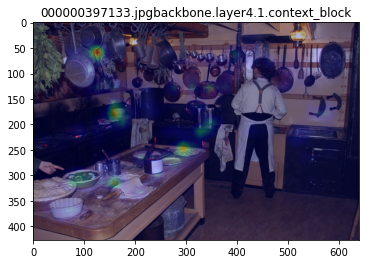

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 1/5000, 0.1 task/s, elapsed: 10s, ETA: 49715s

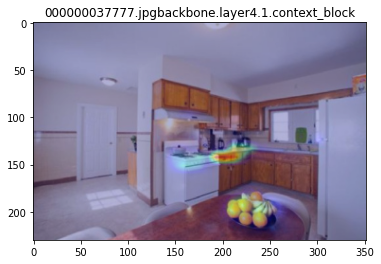

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 2/5000, 0.2 task/s, elapsed: 12s, ETA: 31043s

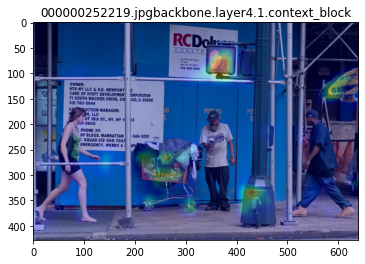

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 3/5000, 0.2 task/s, elapsed: 15s, ETA: 24386s

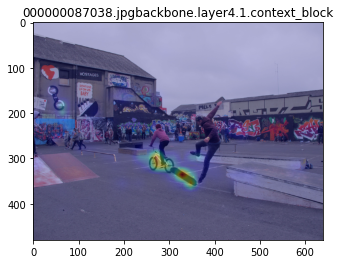

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 4/5000, 0.2 task/s, elapsed: 17s, ETA: 21274s

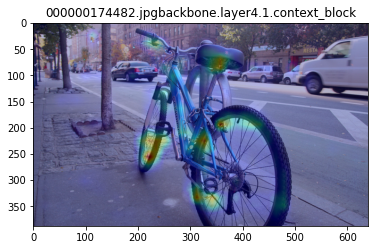

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 5/5000, 0.2 task/s, elapsed: 24s, ETA: 23764s

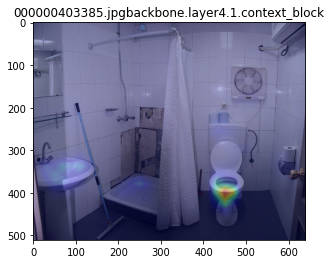

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 6/5000, 0.2 task/s, elapsed: 27s, ETA: 22882s

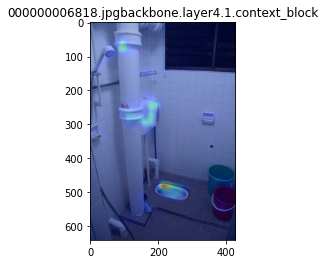

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 7/5000, 0.1 task/s, elapsed: 60s, ETA: 42594s

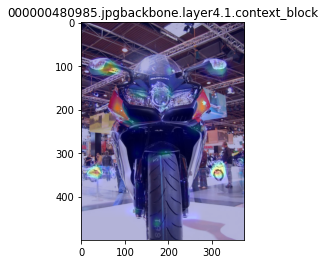

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 8/5000, 0.1 task/s, elapsed: 64s, ETA: 39658s

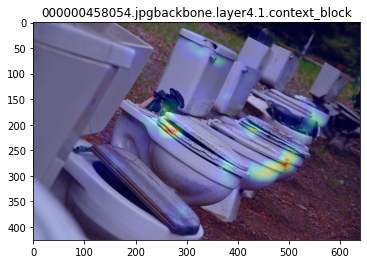

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                                ] 9/5000, 0.1 task/s, elapsed: 66s, ETA: 36791s

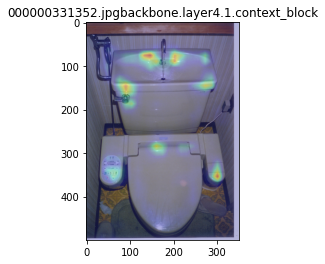

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 10/5000, 0.1 task/s, elapsed: 69s, ETA: 34233s

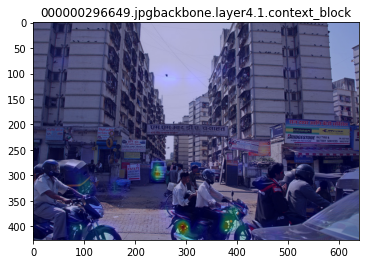

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 11/5000, 0.2 task/s, elapsed: 71s, ETA: 32117s

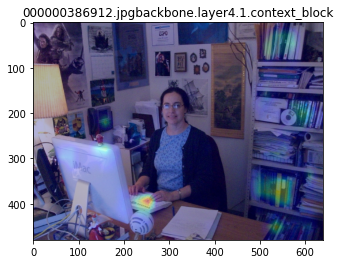

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 12/5000, 0.2 task/s, elapsed: 73s, ETA: 30411s

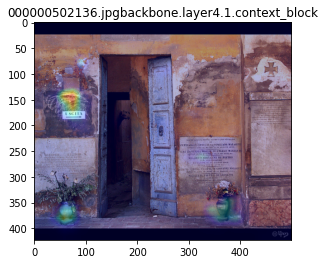

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 13/5000, 0.2 task/s, elapsed: 75s, ETA: 28853s

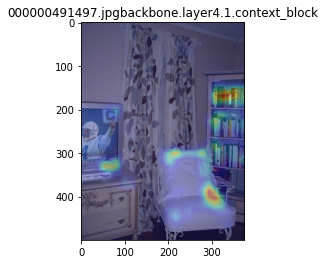

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 14/5000, 0.2 task/s, elapsed: 77s, ETA: 27431s

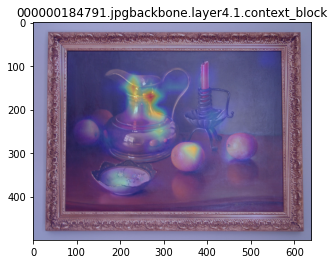

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 15/5000, 0.2 task/s, elapsed: 90s, ETA: 29769s

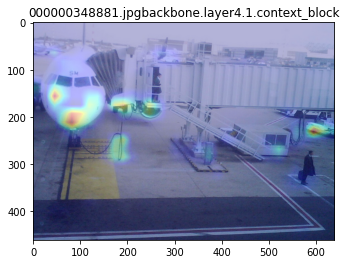

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 16/5000, 0.2 task/s, elapsed: 92s, ETA: 28511s

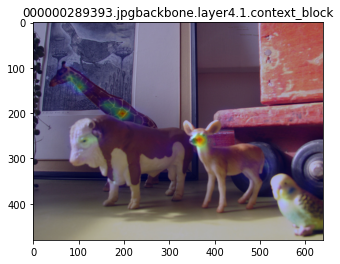

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 17/5000, 0.2 task/s, elapsed: 93s, ETA: 27375s

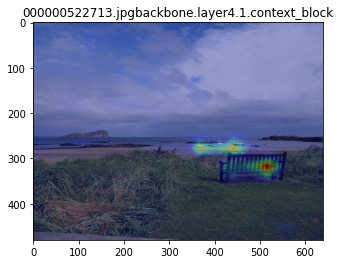

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 18/5000, 0.2 task/s, elapsed: 96s, ETA: 26439s

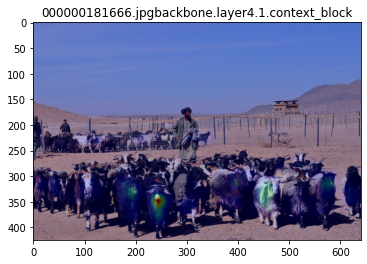

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                               ] 19/5000, 0.2 task/s, elapsed: 98s, ETA: 25646s

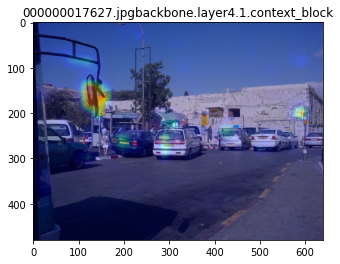

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 20/5000, 0.2 task/s, elapsed: 100s, ETA: 24818s

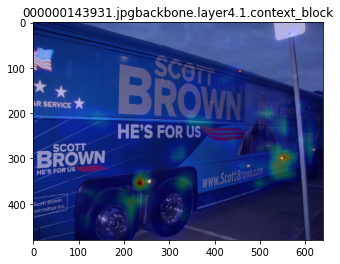

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 21/5000, 0.2 task/s, elapsed: 101s, ETA: 24061s

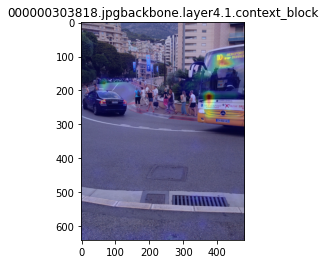

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 22/5000, 0.2 task/s, elapsed: 103s, ETA: 23279s

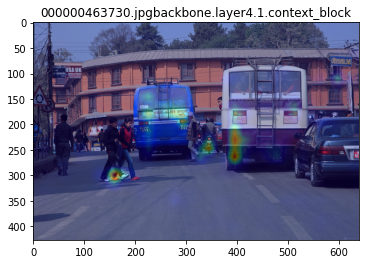

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 23/5000, 0.2 task/s, elapsed: 105s, ETA: 22700s

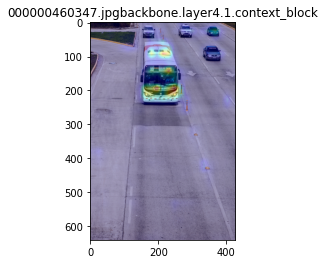

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 24/5000, 0.2 task/s, elapsed: 107s, ETA: 22082s

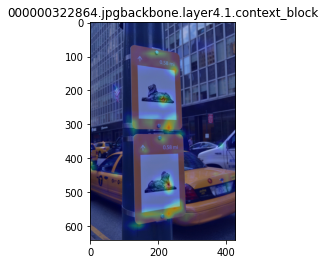

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 25/5000, 0.2 task/s, elapsed: 108s, ETA: 21493s

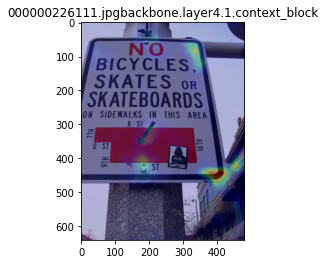

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 26/5000, 0.2 task/s, elapsed: 143s, ETA: 27452s

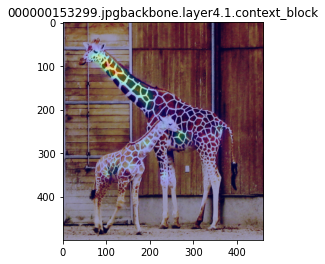

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 27/5000, 0.2 task/s, elapsed: 147s, ETA: 27105s

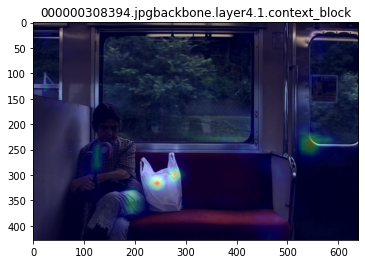

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 28/5000, 0.2 task/s, elapsed: 150s, ETA: 26670s

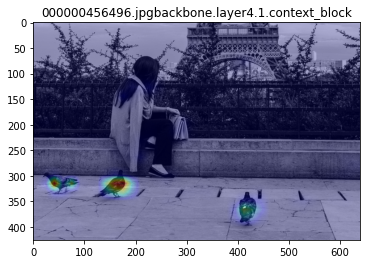

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 29/5000, 0.2 task/s, elapsed: 152s, ETA: 26089s

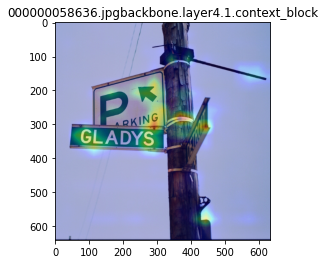

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 30/5000, 0.2 task/s, elapsed: 154s, ETA: 25495s

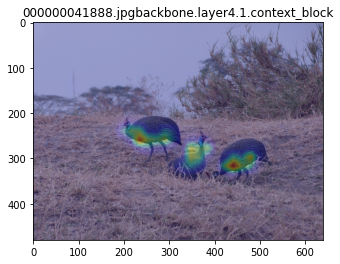

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 31/5000, 0.2 task/s, elapsed: 157s, ETA: 25110s

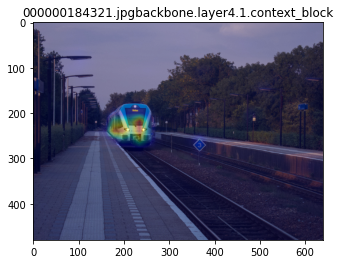

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 32/5000, 0.2 task/s, elapsed: 159s, ETA: 24622s

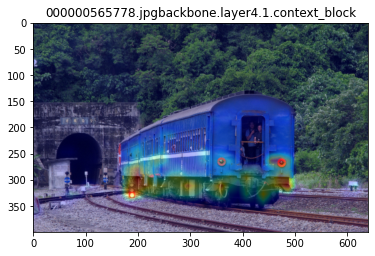

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 33/5000, 0.2 task/s, elapsed: 163s, ETA: 24562s

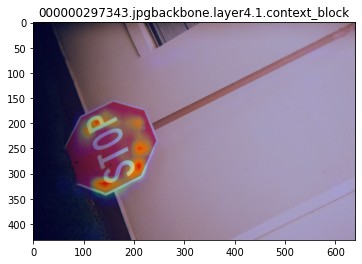

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():
(Pdb) c
[                                              ] 34/5000, 0.2 task/s, elapsed: 165s, ETA: 24138s

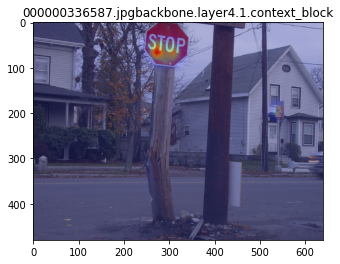

> <ipython-input-3-69c60ce47576>(55)single_gpu_vis()
-> for hidden_name, hidden_output in hidden_outputs.items():


In [ ]:
single_gpu_vis(model, data_loader, True)